In [ ]:
# link & mount to google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libs
import pandas as pd

**Load in data**

In [ ]:
# import pre-processed data from google drive and store in dataframe using pandas function
# split the dataset into 6 different datasets, one for each class
# GAN model will generate samples for one class at a time, therefore dataframe needs to be split by class. Will be joined again after all samples have been generated.
d_Benign = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/d_Benign35.csv')
d_Portscan = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/d_Portscan35.csv')
d_DDoS = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/d_DDoS35.csv')
d_DoS = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/d_DoS35.csv')
d_BruteForce = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/d_BruteForce35.csv')
d_Botnet = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/d_Botnet35.csv')

**Drop label category from each dataframe**

In [ ]:
#colonna superflua perché tanto ho già diviso per classi... la label di ogni df è uguale obv
dfBenign = d_Benign.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)
dfPortscan = d_Portscan.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)
dfDDoS = d_DDoS.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)
dfDoS = d_DoS.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)
dfBruteForce = d_BruteForce.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)
dfBotnet = d_Botnet.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)

In [ ]:
dfDDoS.shape

(95133, 35)

```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
```


##### **Apply power transformer** -- **NO**

In [ ]:
#Min-max normalization is effective in scaling features to a specific range (commonly between 0 and 1),
#and it helps to handle differences in magnitudes between features. If your dataset is already in a suitable range
#and you haven't observed issues related to skewed distributions or outliers, adding a power transform
#might not be necessary and could even introduce unnecessary complexity.

## **Define model architecture**

In [ ]:
# model architecture adapted from https://github.com/ydataai/ydata-synthetic - a model for generating credit card data
# modello GAN
# import os
import numpy as np

# Check that imports for the rest of the file work.
import tensorflow as tf
import tensorflow.compat.v1 as tfv1
!pip install tensorflow-gan
import tensorflow_gan as tfgan
import matplotlib.pyplot as plt
# Allow matplotlib images to render immediately.
%matplotlib inline
tfv1.logging.set_verbosity(tfv1.logging.ERROR)  # Disable noisy outputs.


from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 7.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as pyplot

#PLOTTINO
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
 # plot loss
 pyplot.subplot(2, 1, 1)
 pyplot.plot(d1_hist, label='d-loss-real')
 pyplot.plot(d2_hist, label='d-loss-fake')
 pyplot.plot(g_hist, label='g-loss')
 pyplot.legend()
 # plot discriminator accuracy
 pyplot.subplot(2, 1, 2)
 pyplot.plot(a1_hist, label='acc-real')
 pyplot.plot(a2_hist, label='acc-fake')
 pyplot.legend()

 pyplot.show()

In [ ]:
from keras import backend as K

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [ ]:
#classe del modello intero GAN
class GAN():

    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        #optimizer
        optimizer = tf.keras.optimizers.legacy.Adam(lr, 0.5)


        # Build and compile the discriminator
        self.discriminator.compile(loss=tfgan.losses.wasserstein_generator_loss,
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates samples
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model only the generator is trained
        self.discriminator.trainable = False

        # The discriminator takes generated samples as input and determines validity
        validity = self.discriminator(record)

        # The combined model
        # Trains the generator to try and create samples that will fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss=tfgan.losses.wasserstein_generator_loss, optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))

    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments

        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()

        for epoch in range(epochs):
            # Discriminator
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new samples
            gen_data = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real, d_acc1 = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake, d_acc2 = self.discriminator.train_on_batch(gen_data, fake)
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Generator
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            #Therefore, using the loss values directly is not recommended in GANs.
            #Instead, metrics such as the Inception Score, Frechet Inception Distance (FID score),
            #and perceptual similarity measures (LPIPS) are used for interpreting the results.
            #PERFORMANCE
            d1_hist.append(d_loss_real)
            d2_hist.append(d_loss_fake)
            g_hist.append(g_loss)
            a1_hist.append(d_acc1)
            a2_hist.append(d_acc2)
            # Plot the progress
            #print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            print('==>> %d, dRLoss=%.3f, dFLoss=%.3f gLoss=%.3f, accR=%d, accF=%d' % (epoch, d_loss_real, d_loss_fake, g_loss, int(100*d_acc1), int(100*d_acc2)))
        plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)



#Singola classe del G
class Generator():
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def build_model(self, input_shape, dim, data_dim):
        input_layer = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input_layer)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        # Use sigmoid activation in the output layer to constrain values to [0, 1]
        output_layer = Dense(data_dim, activation='sigmoid')(x)
        return Model(inputs=input_layer, outputs=output_layer)


#Singola classe del D
class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size

    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

**Generating class data**

```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
```


In [ ]:
#Define model params and training params
# set up dataframe for input into model

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# EDIT lines 6 & 7 to choose which class of data to generate
data_columns = dfDDoS.columns
dfDDoS[data_columns] = dfDDoS[data_columns]

# set generator parametes
batch_size = 512
#learning_rate=5e-4
learning_rate=0.001
input_noise = 1 #tra [0,1] perché dati sono normalizzati

input_shape=35 #numeroFeatures
dim=128

# set training parameters
epochs = 3000
log_step = 100

In [ ]:
# assign to variable
generator_parameters = [batch_size, learning_rate, input_noise, input_shape, dim]
training_parameters = ['', epochs, log_step]

Output streaming troncato alle ultime 5000 righe.
16/16 [==============================] - 0s 2ms/step
==>> 500, dRLoss=0.690, dFLoss=0.697 gLoss=0.695, accR=31, accF=56
16/16 [==============================] - 0s 1ms/step
==>> 501, dRLoss=0.692, dFLoss=0.696 gLoss=0.696, accR=29, accF=56
16/16 [==============================] - 0s 1ms/step
==>> 502, dRLoss=0.691, dFLoss=0.695 gLoss=0.698, accR=27, accF=66
16/16 [==============================] - 0s 1ms/step
==>> 503, dRLoss=0.692, dFLoss=0.695 gLoss=0.699, accR=24, accF=75
16/16 [==============================] - 0s 1ms/step
==>> 504, dRLoss=0.693, dFLoss=0.690 gLoss=0.701, accR=25, accF=81
16/16 [==============================] - 0s 1ms/step
==>> 505, dRLoss=0.693, dFLoss=0.689 gLoss=0.702, accR=32, accF=82
16/16 [==============================] - 0s 1ms/step
==>> 506, dRLoss=0.692, dFLoss=0.689 gLoss=0.702, accR=34, accF=75
16/16 [==============================] - 0s 1ms/step
==>> 507, dRLoss=0.692, dFLoss=0.691 gLoss=0.701, accR=40

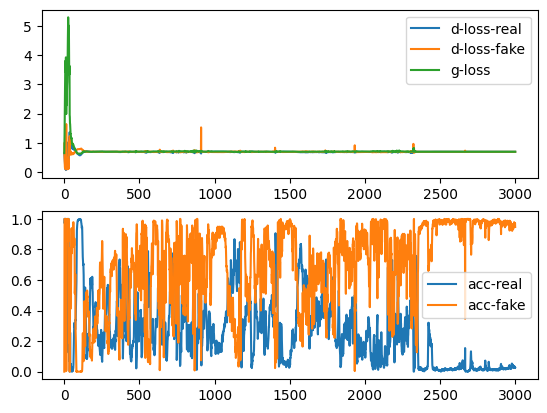

In [ ]:
# training
synthesizer = GAN(generator_parameters)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# change passed in dataframe to select which class is to be generated
synthesizer.train(dfDDoS, training_parameters)

In [ ]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

In [ ]:
np.random.seed(3) # used for retestability

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#noise = np.random.normal(0,1, (1170495, 32)) # number of benign samples to be generated
#noise = np.random.normal(0,1, (70302, 32)) # number of dos hulk samples to be generated
#noise = np.random.normal(0,1, (2922, 32)) # number of ssh patator samples to be generated
#noise = np.random.normal(0,1, (2332, 32)) # number of dos slow loris samples to be generated
#noise = np.random.normal(0,1, (11, 32)) # number of heartbleed samples to be generated
noise = np.random.normal(0,1, (95133, 1)) # number of ddos samples to be generated

[model_name, with_class, generator_model] = models['GAN']

X = generator_model.predict(noise)

2973/2973 [==============================] - 4s 1ms/step


In [ ]:
# Create a dataframe with generated samples, so can be used for evaluation later

gen_ddos_samples = pd.DataFrame(X, columns=data_columns)
# gen_dosHulk_samples = pd.DataFrame(X, columns=data_columns)
# gen_sshPatator_samples = pd.DataFrame(X, columns=data_columns)
# gen_dosSlowloris_samples = pd.DataFrame(X, columns=data_columns)
# gen_heartbleed_samples = pd.DataFrame(X, columns=data_columns)
# gen_infiltration_samples = pd.DataFrame(X, columns=data_columns)

In [ ]:
#gen_benign_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_benign_samples.csv')
# gen_dosHulk_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_dosHulk_samples.csv')
# gen_sshPatator_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_sshPatator_samples.csv')
# gen_dosSlowloris_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_dosSlowloris_samples.csv')
# gen_heartbleed_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_heartbleed_samples.csv')
# gen_infiltration_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_infiltration_samples.csv')

In [ ]:
gen_ddos_samples.head()

,FlowDuration,BwdPacketLengthStd,PacketLengthVariance,DstPort,TotalLengthofFwdPacket,PacketLengthStd,FlowIATMax,FlowPackets/s,FwdPacketLengthMax,BwdPacketLengthMax,...,FwdHeaderLength,FlowIATMean,BwdHeaderLength,FwdRSTFlags,FWDInitWinBytes,BwdInitWinBytes,FwdIATMax,BwdPackets/s,ACKFlagCount,FwdSegSizeMin
0,0.028214,0.844967,0.533952,0.000602,0.000037,0.781153,0.043117,0.000022,0.000222,0.567495,...,0.604134,0.033880,0.633040,0.007540,0.066533,0.001735,0.025047,0.000023,0.000030,0.341248
1,0.014077,0.372883,0.129358,0.000387,0.000063,0.412883,0.025169,0.000033,0.000195,0.292178,...,0.506363,0.008670,0.576697,0.006136,0.122142,0.002842,0.010296,0.000052,0.000081,0.418045
2,0.018179,0.283526,0.090058,0.000176,0.000022,0.327683,0.030941,0.000011,0.000099,0.219151,...,0.433509,0.009810,0.530779,0.004984,0.123032,0.002776,0.015024,0.000017,0.000030,0.426343
3,0.008881,0.692170,0.386754,0.000655,0.000112,0.616090,0.010114,0.000090,0.000741,0.553195,...,0.554853,0.002714,0.536846,0.003336,0.163688,0.001406,0.008076,0.000071,0.000188,0.540355
4,0.078409,0.317714,0.117953,0.000471,0.000066,0.346013,0.109649,0.000036,0.000330,0.249141,...,0.417915,0.023047,0.488594,0.007309,0.113560,0.004827,0.081935,0.000049,0.000087,0.456112


In [ ]:
#Ci sono valori NAN?
nan_in_df = gen_ddos_samples.isnull().sum().any()

# Print the dataframe
print(nan_in_df)

False


In [ ]:
#Quanti valori negativi ci sono?
(gen_ddos_samples < 0).sum().sum()

0

In [ ]:
#CONFRONTO TRA DISTRIBUZIONI

In [ ]:
!pip install sdv

In [ ]:
from sdv.evaluation.single_table import get_column_plot
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic

In [ ]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(dfDDoS)

quality_report = evaluate_quality(
    real_data=dfDDoS,
    synthetic_data=gen_ddos_samples,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 595/595 [00:19<00:00, 31.24it/s]

Overall Score: 60.46%

Properties:
- Column Shapes: 43.07%
- Column Pair Trends: 77.86%


In [ ]:
diagnostic_report = run_diagnostic(
    real_data=dfDDoS,
    synthetic_data=gen_ddos_samples,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 222.63it/s]

Overall Score: 82.21%

Properties:
- Data Validity: 64.42%
- Data Structure: 100.0%


Text(0.5, 1.0, 'synthetic Data')

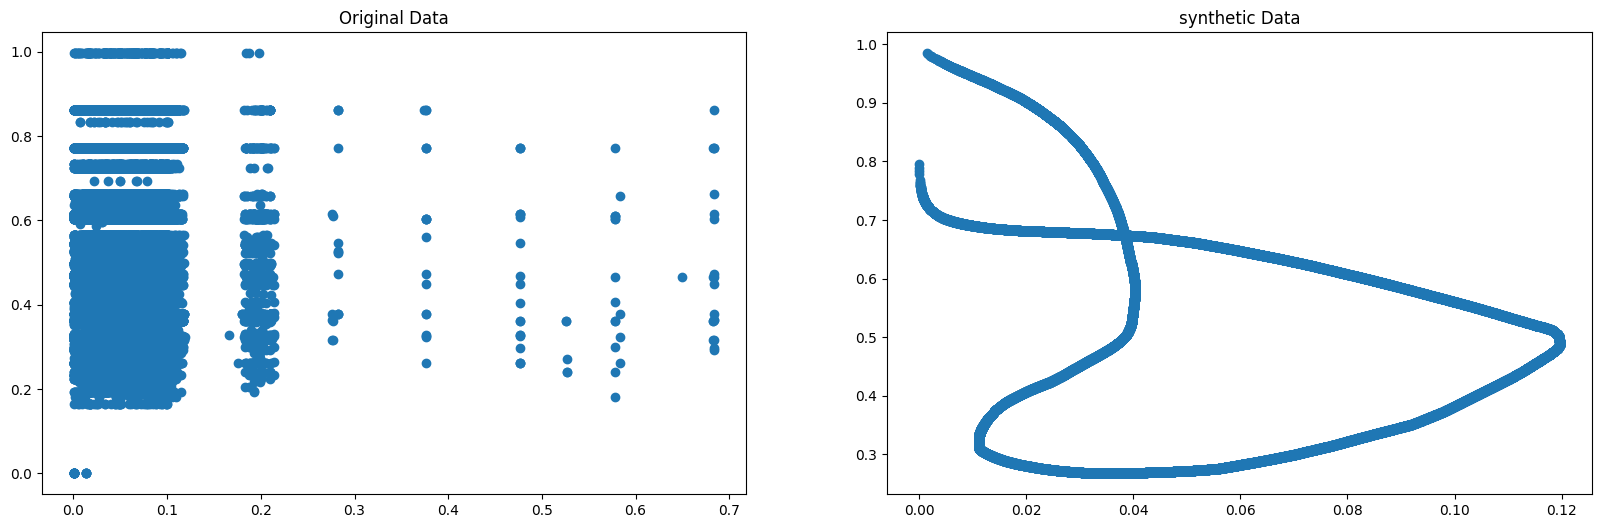

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(dfDDoS.iloc[:, 0], dfDDoS.iloc[:, 1])
ax[1].scatter(gen_ddos_samples.iloc[:, 0], gen_ddos_samples.iloc[:, 1])
ax[0].set_title("Original Data")
ax[1].set_title("synthetic Data")